In [7]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [8]:
# Adjust the path below if your folder name has spaces or different capitalization
!cp '/content/drive/My Drive/Colab Notebooks/real-fake image/kaggle.json' /content/


In [9]:
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [10]:
!pip install kaggle
!kaggle datasets download -d birdy654/cifake-real-and-ai-generated-synthetic-images
!unzip cifake-real-and-ai-generated-synthetic-images.zip -d cifake


Streaming output truncated to the last 5000 lines.
  inflating: cifake/train/REAL/4500 (10).jpg  
  inflating: cifake/train/REAL/4500 (2).jpg  
  inflating: cifake/train/REAL/4500 (3).jpg  
  inflating: cifake/train/REAL/4500 (4).jpg  
  inflating: cifake/train/REAL/4500 (5).jpg  
  inflating: cifake/train/REAL/4500 (6).jpg  
  inflating: cifake/train/REAL/4500 (7).jpg  
  inflating: cifake/train/REAL/4500 (8).jpg  
  inflating: cifake/train/REAL/4500 (9).jpg  
  inflating: cifake/train/REAL/4500.jpg  
  inflating: cifake/train/REAL/4501 (10).jpg  
  inflating: cifake/train/REAL/4501 (2).jpg  
  inflating: cifake/train/REAL/4501 (3).jpg  
  inflating: cifake/train/REAL/4501 (4).jpg  
  inflating: cifake/train/REAL/4501 (5).jpg  
  inflating: cifake/train/REAL/4501 (6).jpg  
  inflating: cifake/train/REAL/4501 (7).jpg  
  inflating: cifake/train/REAL/4501 (8).jpg  
  inflating: cifake/train/REAL/4501 (9).jpg  
  inflating: cifake/train/REAL/4501.jpg  
  inflating: cifake/train/REAL/4502

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [12]:
# Basic image transforms: resize, to tensor, normalize for pretrained models
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# The dataset folders
train_dir = "cifake/train"
test_dir = "cifake/test"

# PyTorch datasets and loaders
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)


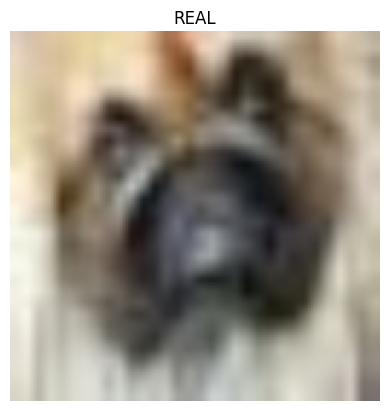

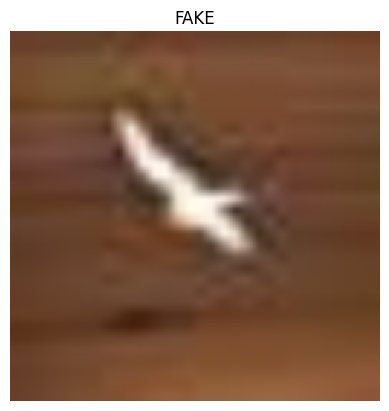

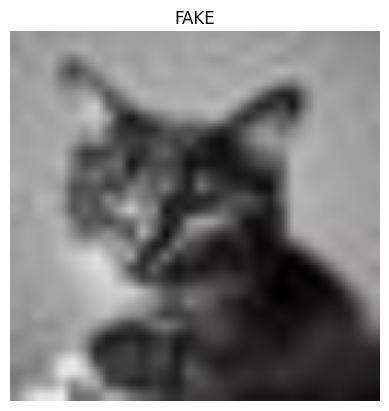

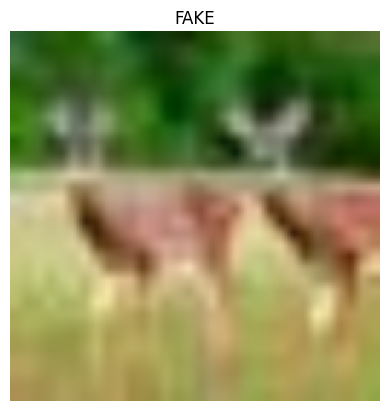

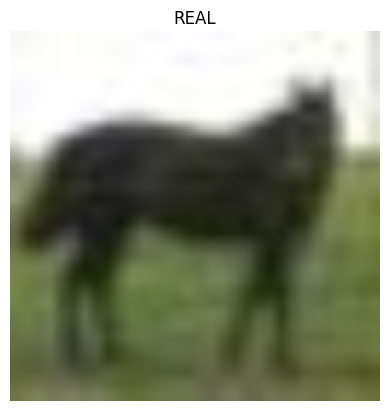

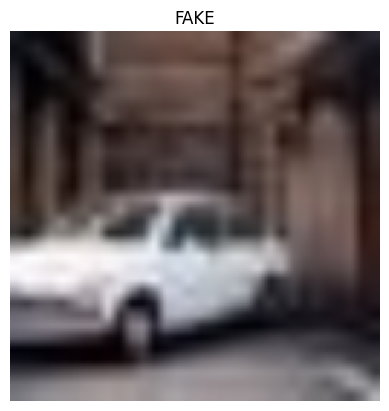

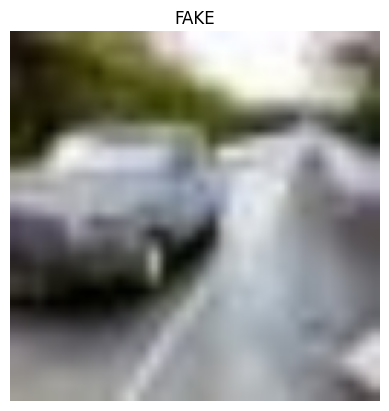

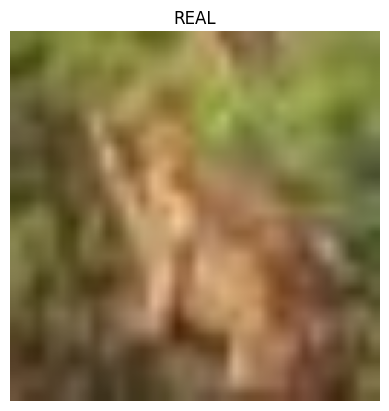

In [13]:
# Class names: class0 is "real", class1 is "AI-generated"
class_names = train_dataset.classes

# Show 8 sample images
import numpy as np
def imshow(img, title):
    npimg = img.numpy().transpose((1, 2, 0))
    plt.imshow(npimg)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Get a batch
images, labels = next(iter(train_loader))
for i in range(8):
    imshow(images[i], f'{class_names[labels[i]]}')


In [14]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 16 * 16, 128), nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x.squeeze(1)  # For binary classification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)


In [15]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(3):
    model.train()
    total_loss = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.float().to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} - Training Loss: {total_loss/len(train_loader):.4f}")


Epoch 1 - Training Loss: 0.3059
Epoch 2 - Training Loss: 0.1752
Epoch 3 - Training Loss: 0.1376


In [16]:
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.float().to(device)
        outputs = torch.sigmoid(model(imgs))
        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)
print(f"Test Accuracy: {correct/total:.2%}")


Test Accuracy: 93.77%


In [18]:
from PIL import Image

def predict_image(img_path):
    img = Image.open(img_path).convert('RGB')
    img = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        out = torch.sigmoid(model(img))
    prob = out.item()
    if prob > 0.5:
        print(f"This image is likely AI-generated! ({prob:.2%} probability)")
    else:
        print(f"This image is likely REAL! ({(1-prob):.2%} probability)")

# after uploading image:
predict_image('/content/drive/My Drive/Colab Notebooks/real-fake image/man&bear.png')


This image is likely REAL! (100.00% probability)
